<a href="https://colab.research.google.com/github/stefisha/Cat-Vision/blob/main/cat_breeed_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🐱 Using Transfer Learning and TensorFlow 2.0 to Classify Different Cat Breeds
Who's that kitty in the window?

Cats are fascinating. But have you ever been lounging at home, seen a cat and not known what breed it is? I have. And then someone says, "it's a Siamese" and you think, how did they know that?

In this project, we're going to be using machine learning to help us identify different breeds of cats.

To do this, we'll be using data from a [cat breed identification competition](https://www.kaggle.com/datasets/shawngano/gano-cat-breed-image-collection). It consists of a collection of 2500+ labelled images of various cat breeds.

This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify multiple different breeds of cats. If we were only trying to classify cats versus dogs, it would be called binary classification (one thing versus another).

Multi-class image classification is an important problem because it's the same kind of technology used in applications ranging from identifying animals in wildlife conservation projects to enhancing pet adoption platforms.

Since the most important step in a deep learning problem is getting the data ready (turning it into numbers), that's what we're going to start with.

We're going to go through the following TensorFlow/Deep Learning workflow:

1. Get data ready (download from a cat breed competition site, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model ([TensorFlow Hub](https://www.tensorflow.org/hub), `tf.keras.applications`, [TensorBoard](https://www.tensorflow.org/tensorboard), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, share, and reloading your model (once you're happy with the results).

For preprocessing our data, we're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub.

The process of using a pretrained model and adapting it to your own problem is called **transfer learning**. We do this because rather than train our own model from scratch (which could be timely and expensive), we leverage the patterns of another model which has been trained to classify images.

## Getting our workspace ready

In [1]:
# Use the '-d' parameter as the destination for where the files should go
#!unzip "/content/drive/MyDrive/Cat Breeds Classification/archive.zip" -d "/content/drive/MyDrive/Data/"

In [2]:
!nvidia-smi

Mon Feb 19 23:59:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow import keras
from keras.layers import *
from keras.models import Model
from keras.applications import MobileNetV2

In [4]:
import os
import pathlib
import datetime
from glob import glob
from PIL import Image

After the imports we need to load the data. Since all the images are in seperate folders, we need to check if there are any problematic ones.

In [5]:
# Base directory containing subfolders for each category
PATH = '/content/drive/MyDrive/Cat Breeds Classification/Gano-Cat-Breeds-V1_1/'

In [6]:
# def check_images_in_directory(directory):
#     problematic_files = []
#     for root, _, files in os.walk(directory):
#         for file in files:
#             if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
#                 try:
#                     with Image.open(os.path.join(root, file)) as img:
#                         img.verify()  # Verify the image integrity
#                 except (IOError, SyntaxError) as e:
#                     print('Bad file:', os.path.join(root, file))  # Print out the names of corrupt files
#                     problematic_files.append(os.path.join(root, file))
#     return problematic_files

# problematic_files = check_images_in_directory(PATH)

# # Optionally, remove or manually inspect problematic files
# print(f"Found {len(problematic_files)} problematic files.")

Now we can load all the images, we put them into a dataset containing filepaths and labels, excluding the one problematic image.

In [7]:
def make_dataFrame(data):
    path = pathlib.Path(data)
    filepaths = list(path.glob(r"*/*.*"))  # This will now capture all files
    # Filter out non-image files and the problematic image
    filepaths = [filepath for filepath in filepaths if filepath.suffix.lower() in ['.jpg', '.png', '.jpeg', '.bmp', '.gif']
                 and str(filepath) != "/content/drive/MyDrive/Cat Breeds Classification/Gano-Cat-Breeds-V1_1/American Bobtail/AmericanBobtail-33999199_1891.jpg"]
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    d1 = pd.Series(filepaths, name='filepaths').astype(str)
    d2 = pd.Series(labels, name='labels')
    df = pd.concat([d1, d2], axis=1)
    return df


In [8]:
dataset = make_dataFrame(PATH)
dataset

,filepaths,labels
0,/content/drive/MyDrive/Cat Breeds Classificati...,Abyssinian
1,/content/drive/MyDrive/Cat Breeds Classificati...,Abyssinian
2,/content/drive/MyDrive/Cat Breeds Classificati...,Abyssinian
3,/content/drive/MyDrive/Cat Breeds Classificati...,Abyssinian
4,/content/drive/MyDrive/Cat Breeds Classificati...,Abyssinian
...,...,...
5619,/content/drive/MyDrive/Cat Breeds Classificati...,Tuxedo
5620,/content/drive/MyDrive/Cat Breeds Classificati...,Tuxedo
5621,/content/drive/MyDrive/Cat Breeds Classificati...,Tuxedo
5622,/content/drive/MyDrive/Cat Breeds Classificati...,Tuxedo


In [9]:
class_names = dataset['labels'].unique()
class_names

array(['Abyssinian', 'American Bobtail', 'American Shorthair', 'Bengal',
       'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau',
       'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese',
       'Sphynx', 'Tuxedo'], dtype=object)

In [10]:
print(dataset.describe())
print(dataset.head())

                                                filepaths      labels
count                                                5624        5624
unique                                               5624          15
top     /content/drive/MyDrive/Cat Breeds Classificati...  Abyssinian
freq                                                    1         375
                                           filepaths      labels
0  /content/drive/MyDrive/Cat Breeds Classificati...  Abyssinian
1  /content/drive/MyDrive/Cat Breeds Classificati...  Abyssinian
2  /content/drive/MyDrive/Cat Breeds Classificati...  Abyssinian
3  /content/drive/MyDrive/Cat Breeds Classificati...  Abyssinian
4  /content/drive/MyDrive/Cat Breeds Classificati...  Abyssinian


Looking at this, we can see there are 5624 different filepaths (meaning 5624 different images) and 15 different breeds.

Let's figure out how many images there are of each breed.

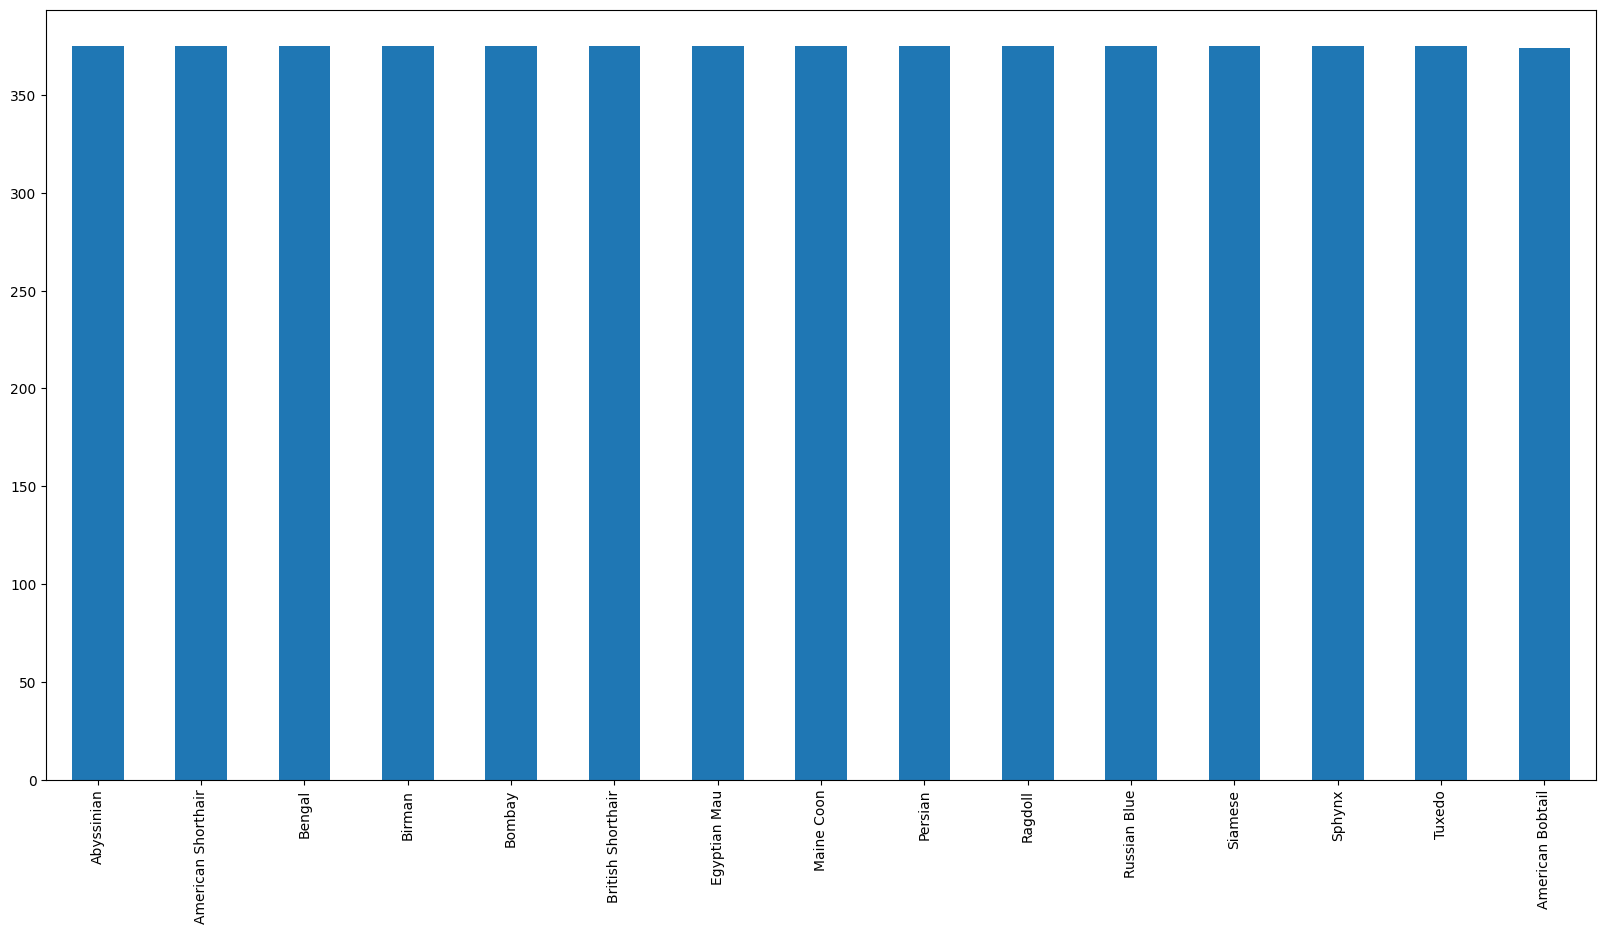

In [11]:
dataset['labels'].value_counts().plot.bar(figsize=(20,10));

It appears that there is an equal amount of images for each race, which is good as our model will be able to learn properly. If there was a substantionaly larger amount of samples for one breed, the model would become really good at detecting just that one breed, at the expense of the others. Conversely, if one breed was very unrepresented, the model would most likely not be able to recognize it correctly.

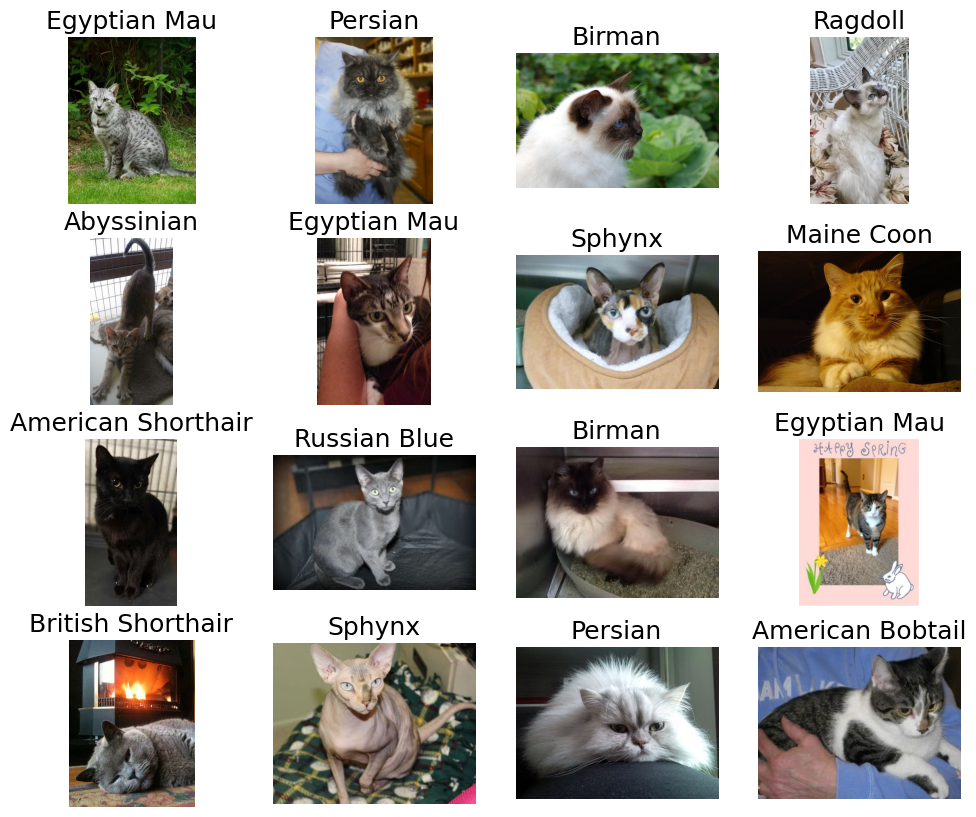

In [12]:
# Visualize some images and breeds
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,10))
for i,ax in enumerate(axes.flat):
    idx = np.random.randint(1,5624)
    x = plt.imread(dataset.iloc[idx]['filepaths'])
    ax.imshow(x)
    ax.set_title(dataset['labels'][idx], fontsize=18)
    ax.set_axis_off()
plt.show()

In [13]:
train_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

In [14]:
train_dataset = train_generator.flow_from_dataframe(dataframe=dataset,
                                                    x_col='filepaths',
                                                    y_col='labels',
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='training',
                                                    shuffle=True)

Found 5624 validated image filenames belonging to 15 classes.


In [17]:
# Load MobileNetV2 base model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

# Add custom top layers
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

# Create the model
model = Model(inputs, outputs)


9406464/9406464 [==============================] - 0s 0us/step


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                             

In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(train_dataset,
          epochs=20,
          callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy',
                                                  mode='max',
                                                  patience=3)])

Epoch 1/20
176/176 [==============================] - 1830s 10s/step - loss: 1.4062 - accuracy: 0.5489
Epoch 2/20
176/176 [==============================] - 32s 184ms/step - loss: 0.9365 - accuracy: 0.6840
Epoch 3/20
176/176 [==============================] - 33s 186ms/step - loss: 0.8105 - accuracy: 0.7219
Epoch 4/20
176/176 [==============================] - 31s 179ms/step - loss: 0.7537 - accuracy: 0.7397
Epoch 5/20
176/176 [==============================] - 33s 188ms/step - loss: 0.6923 - accuracy: 0.7592
Epoch 6/20
176/176 [==============================] - 33s 186ms/step - loss: 0.6264 - accuracy: 0.7845
Epoch 7/20
176/176 [==============================] - 32s 181ms/step - loss: 0.6003 - accuracy: 0.7946
Epoch 8/20
176/176 [==============================] - 31s 179ms/step - loss: 0.5651 - accuracy: 0.7985
Epoch 9/20
176/176 [==============================] - 33s 186ms/step - loss: 0.5319 - accuracy: 0.8131
Epoch 10/20
176/176 [==============================] - 32s 181ms/step - l

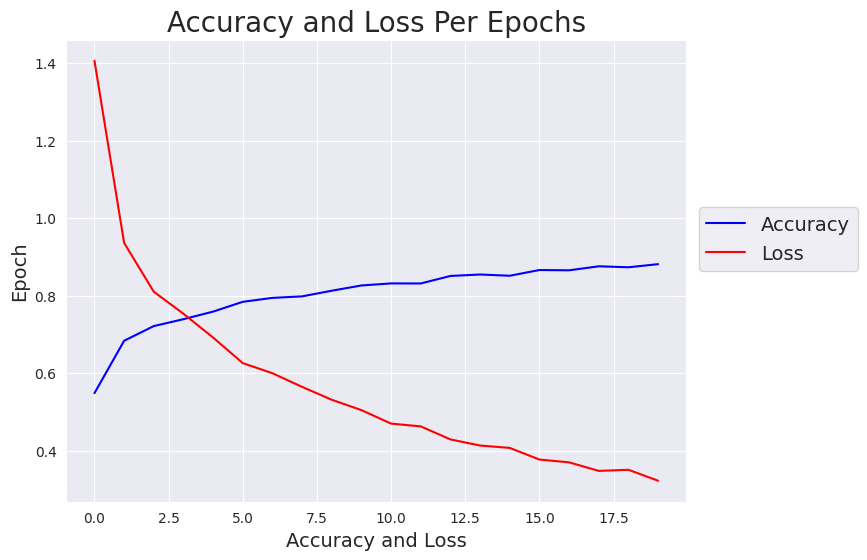

In [26]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'],c='blue')
plt.plot(history.history['loss'],c='red')
plt.title("Accuracy and Loss Per Epochs", fontsize=20)
plt.xlabel("Accuracy and Loss", fontsize=14)
plt.ylabel("Epoch", fontsize=14)
plt.legend(["Accuracy","Loss"], fontsize=14,loc=[1.02,0.5])
plt.show();

In [36]:
def predict_cat_breed(image, model):
    img = keras.preprocessing.image.load_img(image)
    img_arr = keras.utils.img_to_array(img)
    img_arr = img_arr/255.
    img_arr = tf.image.resize(img_arr,[224,224])
    pred = np.argmax(model.predict(np.expand_dims(img_arr, axis=0)))
    prediction = class_names[pred]

    plt.figure(figsize=(2,2), dpi=200)
    plt.imshow(img)
    plt.title(prediction, fontsize=12)
    plt.axis('off')

1/1 [==============================] - 0s 37ms/step


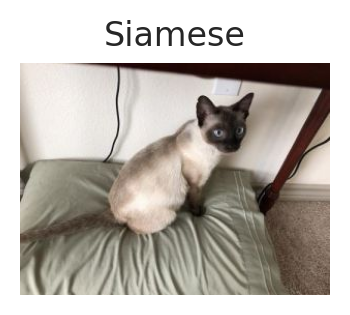

In [37]:
import tensorflow as tf
image = '/content/drive/MyDrive/Cat Breeds Classification/Gano-Cat-Breeds-V1_1/Siamese/Siamese-45150207_7156.jpg'
predict_cat_breed(image=image, model=model)

In [29]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/My Drive/Data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [32]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path)
  return model

In [33]:
# Save our model trained on 1000 images
save_model(model, suffix="cat-vision-imagenet")

Saving model to: drive/My Drive/Data/models/20240220-00501708390224-cat-vision-imagenet.h5...


'drive/My Drive/Data/models/20240220-00501708390224-cat-vision-imagenet.h5'